# Waste Manager- Part 2: Waste Load Predictor

## Introduction

Spending two decades in Dhaka, one of the most polluted cities in the world, has given us a deep understanding of the critical role waste management plays in creating a sustainable urban environment. Leveraging our newly acquired knowledge of neural networks, we aim to develop a model capable of predicting waste load, enabling more efficient and effective waste management solutions.

We leveraged the waste management data of Austin, Texas from the [open data portal of City of Austin](https://data.austintexas.gov/Utilities-and-City-Services/Waste-Collection-Diversion-Report-daily-/mbnu-4wq9/about_data) for this project.

## Data Preparation

While we were taught Pytorh in class, we wanted to explore the capabilities of Keras for this project.

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
# Loading the Dataset
file_path = '/content/Waste_Collection.csv'
df = pd.read_csv(file_path)

After loading the data, we focused on getting rid off extreme values that can impact the predictions.

In [ ]:
# Selecting only numerical columns
numerical_data = df.select_dtypes(include=[np.number]).values

# Replacing NaNs with column mean
numerical_data = np.nan_to_num(numerical_data, nan=np.nanmean(numerical_data, axis=0))

# Computing mean and standard deviation
mean = np.mean(numerical_data, axis=0)
std = np.std(numerical_data, axis=0)

# Calculating Z-scores
z_scores = np.abs((numerical_data - mean) / std)

# Filtering rows to get rid off extreme values
threshold = 2
mask = (z_scores < threshold).all(axis=1)

# Applying mask to the original DataFrame
data = df[mask]

# Inspecting the resulting DataFrame
print("Filtered dataset:")
print(f"Number of rows before filtering: {len(df)}")
print(f"Number of rows after filtering: {len(data)}")

Filtered dataset:
Number of rows before filtering: 502519
Number of rows after filtering: 490225


In [ ]:
print(data.columns)

Index(['Report Date', 'Load Type', 'Load Time', 'Load Weight', 'Dropoff Site',
       'Route Type', 'Route Number', 'Load ID'],
      dtype='object')


Now we will focus on leveraging the date column to derive temporal features such as year, month and day. Additionally, we will also encode categorical features such as drop-off site and load type.

In [ ]:
# Ensuring column names are consistent
data.columns = data.columns.str.strip()
data.columns = data.columns.str.lower()

# Defining categorical columns
categorical_cols = ['load type', 'dropoff site', 'route type', 'route number']

# Filtering out missing columns
available_categorical_cols = [col for col in categorical_cols if col in data.columns]
missing_cols = [col for col in categorical_cols if col not in data.columns]

# Notifying about missing columns
if missing_cols:
    print(f"Missing columns: {missing_cols}")
    print("Proceeding with available columns:", available_categorical_cols)

# Converting date columns
data['report date'] = pd.to_datetime(data['report date'])
data['load time'] = pd.to_datetime(data['load time'])

# Extracting temporal features
data['year'] = data['report date'].dt.year
data['month'] = data['report date'].dt.month
data['day'] = data['report date'].dt.day
data['dayofweek'] = data['report date'].dt.dayofweek
data['hour'] = data['load time'].dt.hour

# Encoding categorical features
label_encoder_load_type = LabelEncoder()
data['load_type_encoded'] = label_encoder_load_type.fit_transform(data['load type'])

label_encoder_dropoff_site = LabelEncoder()
data['dropoff_site_encoded'] = label_encoder_dropoff_site.fit_transform(data['dropoff site'])

# Selecting relevant features and target
features = ['year', 'month', 'day', 'dropoff_site_encoded', 'load_type_encoded']
X = data[features].values
y = data['load weight'].values


<ipython-input-95-5af70e3f3316>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['report date'] = pd.to_datetime(data['report date'])
<ipython-input-95-5af70e3f3316>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['load time'] = pd.to_datetime(data['load time'])
<ipython-input-95-5af70e3f3316>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

We first normalize the features and target using MinMaxScaler, then reshape the data into sequences suitable for RNN input. The dataset is split into training (80%), validation (10%), and test (10%) sets to ensure proper model training and evaluation.

In [ ]:
# Normalizing features and target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshaping Data for RNN
n_timesteps = 10
n_features = X_scaled.shape[1]

# Ensuring dataset size is divisible by timesteps
X_scaled = X_scaled[:X_scaled.shape[0] // n_timesteps * n_timesteps]
y_scaled = y_scaled[:y_scaled.shape[0] // n_timesteps * n_timesteps]

# Reshaping for RNN input
X_reshaped = X_scaled.reshape(-1, n_timesteps, n_features)
y_reshaped = y_scaled.reshape(-1, n_timesteps, 1)

# Splitting into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

We then handle any missing values in the train and validation dataset. We decided to delete the around 10% missing values instead of introducing mean values as such may alter the true patterns of the dataset and decrease model's predictive accuracy.

In [ ]:
# Handling missing values
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

In [ ]:
print(np.isnan(X_train).any(), np.isinf(X_train).any())
print(np.isnan(y_train).any(), np.isinf(y_train).any())

False False
False False


In [ ]:
# Handling missing values
X_val = np.nan_to_num(X_val)
y_val = np.nan_to_num(y_val)

In [ ]:
print(np.isnan(X_val).any(), np.isinf(X_val).any())
print(np.isnan(y_val).any(), np.isinf(y_val).any())

False False
False False


In [ ]:
# Detecting overlapping records
train_indices = set(range(len(X_train)))
test_indices = set(range(len(X_test)))

overlap = train_indices & test_indices
print(f"Number of overlapping records: {len(overlap)}")

In [ ]:
# Detecting overlapping indices
train_rows = [tuple(row.flatten()) for row in X_train]
test_rows = [tuple(row.flatten()) for row in X_test]
overlap_indices = [i for i, row in enumerate(train_rows) if row in test_rows]

# Removing overlapping records
X_train_cleaned = np.delete(X_train, overlap_indices, axis=0)
y_train_cleaned = np.delete(y_train, overlap_indices, axis=0)

print(f"Training set size after cleaning: {X_train_cleaned.shape[0]}")

## Modeling

We compared the performance of three models- Vanilla RNN, LSTM and GRU to understand which predicts the waste weight the best. We select Mean Absolute Error as our loss function.

In [ ]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(learning_rate= 0.001, clipvalue=1.0)

In [ ]:
# Comparing RNN models
def create_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(500, activation='relu', return_sequences=True, input_shape=input_shape),
        SimpleRNN(250),
        Dense(125, activation='relu'),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(500, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(250),
        Dense(125, activation='relu'),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

def create_gru_model(input_shape):
    model = Sequential([
        GRU(500, activation='tanh', return_sequences=True, input_shape=input_shape),
        GRU(250),
        Dense(125, activation='relu'),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

## Training

We train all three models on 100 epochs and visualize the training and validation loss.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Defining input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Creating models
models = {
    'Vanilla RNN': create_rnn_model(input_shape),
    'LSTM': create_lstm_model(input_shape),
    'GRU': create_gru_model(input_shape)
}

# Training each model and store results
history_dict = {}
for name, model in models.items():
    print(f"Training {name}...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    history_dict[name] = history


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Vanilla RNN...
Epoch 1/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0750 - mean_absolute_error: 0.2290 - val_loss: 0.0726 - val_mean_absolute_error: 0.2269
Epoch 2/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0722 - mean_absolute_error: 0.2253 - val_loss: 0.0718 - val_mean_absolute_error: 0.2248
Epoch 3/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0722 - mean_absolute_error: 0.2255 - val_loss: 0.0721 - val_mean_absolute_error: 0.2262
Epoch 4/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0720 - mean_absolute_error: 0.2253 - val_loss: 0.0718 - val_mean_absolute_error: 0.2241
Epoch 5/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0722 - mean_absolute_error: 0.2255 - val_loss: 0.0720 - val_mean_absolute_error: 0.2238
Epoch 6/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0716 - mean_absolute_error: 0.2245 - val_loss: 0.0718 - val_mean_absolute_error: 0.2238
Epoch 7/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - 

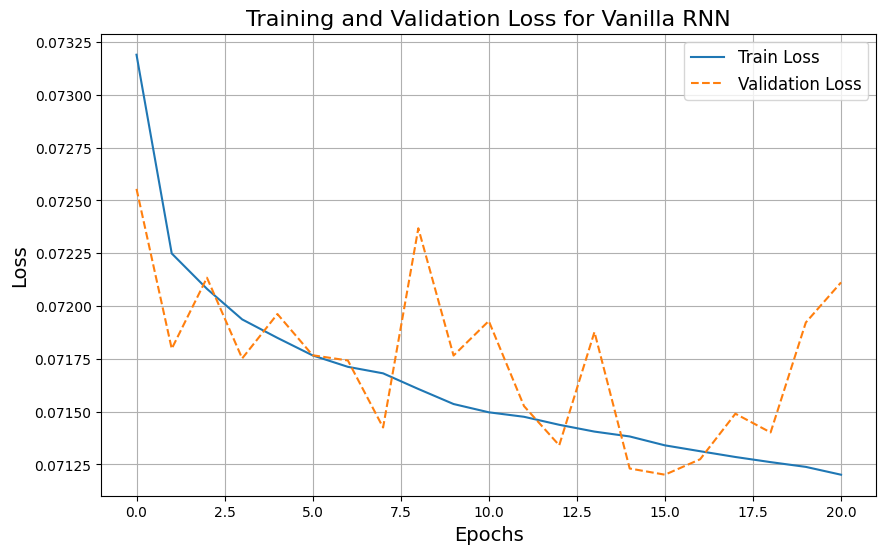

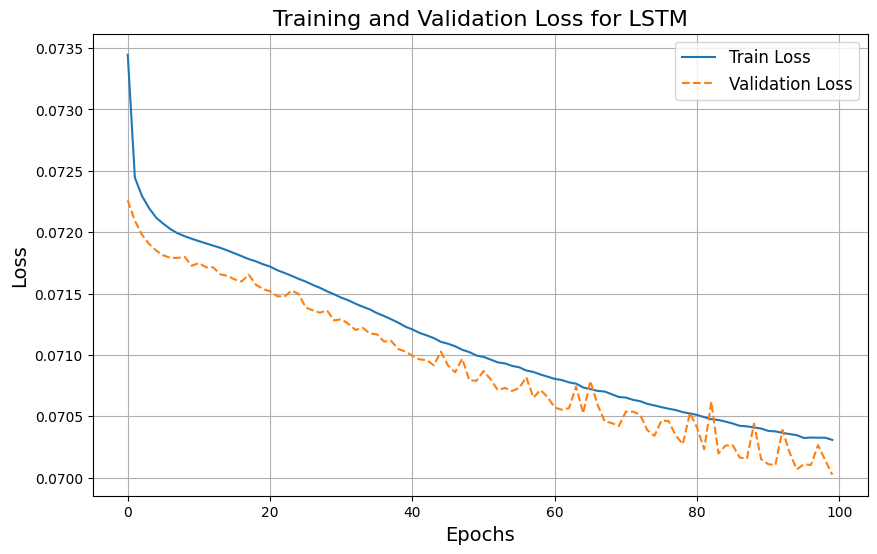

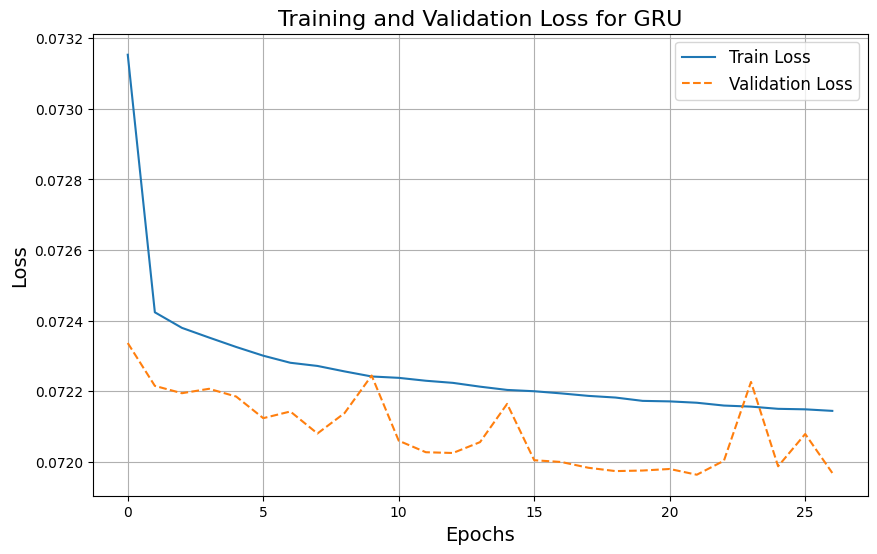

In [ ]:
import matplotlib.pyplot as plt

# Looping through each model and plotting its training and validation loss
for name, history in history_dict.items():
    train_loss = history.history['loss']  # Training loss
    val_loss = history.history['val_loss']  # Validation loss

    # Creating a figure for each model
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss', linestyle='-')
    plt.plot(val_loss, label='Validation Loss', linestyle='--')
    plt.title(f'Training and Validation Loss for {name}', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


The Vanilla RNN shows significant fluctuations in validation loss and starts overfitting after 15 epochs, indicating poor generalization. The GRU demonstrates smoother training loss with moderate validation loss fluctuations, but it lacks the stability observed in the LSTM. The LSTM outperforms both, with consistently decreasing training and validation losses, indicating robust learning and better generalization, making it the best model among the three.

## Testing

In [ ]:
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

In [ ]:
# Evaluate all models on the test set
test_results = {}
for name, model in models.items():
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    test_results[name] = {'Loss': loss, 'MAE': mae}

# Find the best model
best_model_name = min(test_results, key=lambda x: test_results[x]['MAE'])
best_model = models[best_model_name]

print("Test Results:")
for name, result in test_results.items():
    print(f"{name}: Loss={result['Loss']}, MAE={result['MAE']}")
print(f"Best Model: {best_model_name}")

Test Results:
Vanilla RNN: Loss=0.07120925188064575, MAE=0.2238778918981552
LSTM: Loss=0.07008413225412369, MAE=0.22181865572929382
GRU: Loss=0.07206990569829941, MAE=0.22552825510501862
Best Model: LSTM


The LSTM model stands out as the best model for test dataset as well. Therefore, we will select this model and make a final check to see how the predictions compare with actual data.  

In [ ]:
# Generating Predictions
predictions = models['LSTM'].predict(X_test)

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


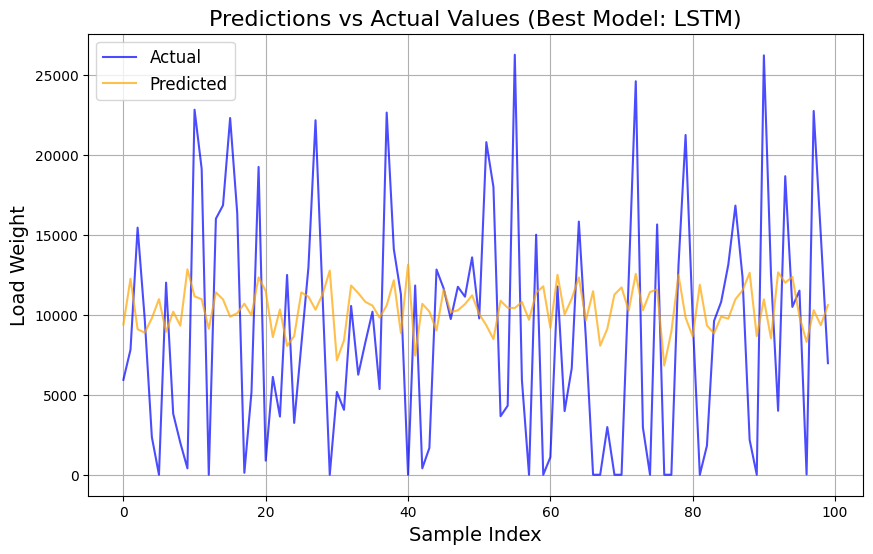

In [ ]:
# Plotting predictions vs. actual values
import matplotlib.pyplot as plt

# Inverting scaling to get original values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
predictions_original = scaler_y.inverse_transform(predictions)

# Plotting a subset of the data for better clarity
subset = 100
start_index = 0
end_index = start_index + subset

plt.figure(figsize=(10, 6))
plt.plot(y_test_original[start_index:end_index], label='Actual', color='blue', alpha=0.7, linewidth=1.5)
plt.plot(predictions_original[start_index:end_index], label='Predicted', color='orange', alpha=0.7, linewidth=1.5)
plt.title(f'Predictions vs Actual Values (Best Model: {best_model_name})', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Load Weight', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# Step 7: Save the Model (Optional)
model.save('waste_load_rnn_model.keras')

## Recommendations
The results indicate that the LSTM, the best model determined, is underfitting, as the predicted waste load values fail to capture the variability and trends present in the actual values. This underperformance suggests that the current input features—year, month, day, load type, and drop-off site—may not sufficiently represent the underlying patterns influencing waste load.

Please note that we have already tried various strategies, such as changing the loss function, optimizers, and learning schedulers, but the performance did not significantly improve. Therefore, to enhance model performance, we believe we will have to leverage feature engineering by **incorporating lag variables to account for temporal dependencies, interaction variables to capture relationships between features, and possibly additional external variables like weather or population density**.

## Conclusion

With the right fixes, the predictive accuracy of this model can be improved and it can be deployed on cloud platforms like AWS or Azure to optimize waste collection schedules, allocate resources efficiently, and support data-driven decisions for urban waste management systems.